<a href="https://colab.research.google.com/github/ProfAI/tf00/blob/master/11%20-%20Serie%20Storiche/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2020-07-08 12:26:16--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.1s    

2020-07-08 12:26:16 (87.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
from sklearn.preprocessing import StandardScaler

In [63]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [64]:
data = df["T (degC)"].values

In [65]:
batch_data = len(data)
history_size = 20
target_future = 6

X = []
y = []

for i in range(0, data.shape[0]-history_size*target_future):
  X.append(np.reshape(data[i:i+history_size], (history_size, 1)))
  y.append(data[i+history_size*target_future])

X = np.array(X)
y = np.array(y)

In [66]:
data[120]

-4.93

In [67]:
y[0]

-4.93

In [49]:
TEST_SPLIT = 0.2

test_size = int(X.shape[0]*TEST_SPLIT)
train_size = X.shape[0]-test_size

X_train = X[:train_size,:,:]
X_test = X[train_size:train_size+test_size,:,:]

y_train = y[:train_size]
y_test = y[train_size:train_size+test_size]

In [50]:
mean_value = X_train.mean()
std_value = X_train.std()

X_train = (X_train-mean_value)/std_value
X_test = (X_test-mean_value)/std_value

In [51]:
model = Sequential()
model.add(LSTM(8, input_shape=[history_size,1]))
model.add(Dense(1))

In [52]:
model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
10511/10511 [==============================] - 56s 5ms/step - loss: 3.5731
Epoch 2/5
10511/10511 [==============================] - 56s 5ms/step - loss: 3.0339
Epoch 3/5
10511/10511 [==============================] - 56s 5ms/step - loss: 2.9911
Epoch 4/5
10511/10511 [==============================] - 57s 5ms/step - loss: 2.9620
Epoch 5/5
10511/10511 [==============================] - 56s 5ms/step - loss: 2.9426


In [53]:
model.evaluate(X_test, y_test)

2628/2628 [==============================] - 8s 3ms/step - loss: 2.9209


2.9208521842956543

In [56]:
y_pred = model.predict(X_test)

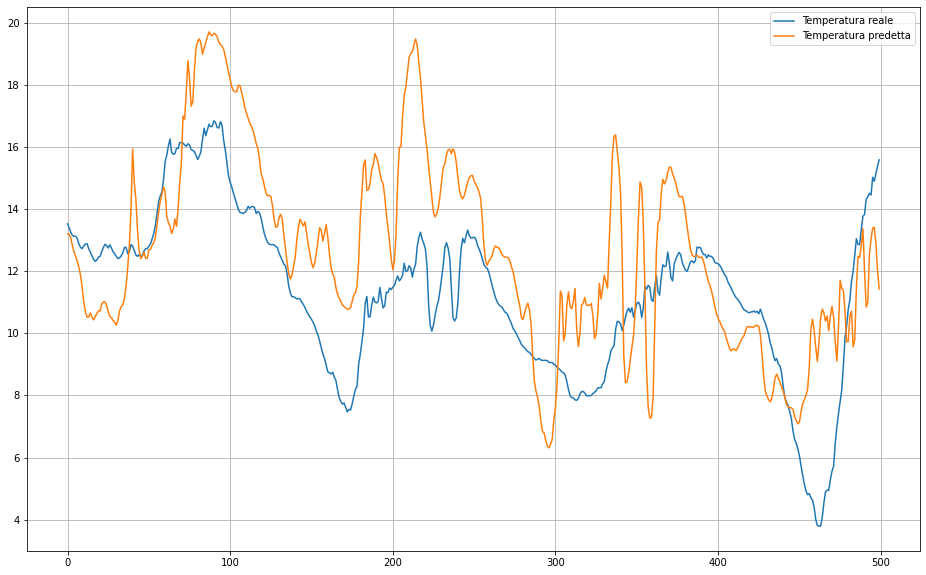

In [57]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.plot(y_test[:500], label="Temperatura reale")
plt.plot(y_pred[:500], label="Temperatura predetta")
plt.legend()